# Kaggle Titanic Notebook

## Required packages and follow-up notes
List of packages used in this notebook. 

As previously explored, when using a single machine learning classifier (random forest for example), the error is not low enough. As also explored in lower sections, the high error is due to a high bias problem, and not a high variance. Therefore, an option to improve the high bias problem is to add complexity to the algorithm. One way to do so is ensembling, which combines the results of distinct machine learning classifier in order to produce predictions based on multiple (ideally uncorrelated) classifiers.

To further improve the performance of each classifier, it is possible to tune the hyperparameters using grid search.

`matplotlib` is used to visualize data throughout the notebook, especially for exploratory data analysis.

In [547]:
# Common data manipulation lib
import pandas as pd
import numpy as np

# Machine learning classifiers used for ensembling
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Used to optimize hyperparameters of some classifiers
from sklearn.model_selection import GridSearchCV

# Ensemble multiple classifiers to reduce bias
from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.ensemble import StackingClassifier  # Only available in scikit-learn 0.22

# Evaluation metric
from sklearn.metrics import accuracy_score

# Data visualisation
import matplotlib.pyplot as plt

## Import data

In [429]:
df = pd.read_csv('./data/train.csv')
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## Exploratory data analysis

### Shape of the data

In [430]:
df.shape

(891, 12)

### What is the base survival rate to begin with?
The algorithm should not simply learn to say that people on the Titanic will most likely die in general, regardless of features.

In [431]:
df[df['Survived'] == 1].shape[0] / df.shape[0]

0.3838383838383838

### Are there any columns having missing data?

In [432]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We see that the `Age` and `Cabin` columns have a significant amount of missing data. If those are to be used as features, data imputation techniques shall be used to fill the missing values.

### What is the average of metrics grouped by `Survived` value?

In [460]:
df.groupby(['Survived']).mean().sort_values('Pclass').head(2)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,HasCabin,IsAlone,NbFamilyMembers
Survived,,,,,,,,,,,
1,444.368421,1.950292,0.681287,28.448040,0.473684,0.464912,48.395408,0.450000,0.397661,0.476608,0.938596
0,447.016393,2.531876,0.147541,29.819165,0.553734,0.329690,22.117887,0.307832,0.123862,0.681239,0.883424


## Data transformation
`scikit-learn` machine learning classifiers only support numeric features. Some mapping will be required in order to transform text data such as the `sex` feature into numeric data.

Additionally, as explored in the previous section, data imputation is required for some fields containing missing values.

Finally, a feature engineering section is present in order to add complexity to the model. As explained at the beginning of the notebook, training a classifier using the base data resulted in high bias problem. One way to counter this problem is to add new features to the model. The addition of new features increases the complexity, and thus, has more chances to lower the bias.


### Sex: string to numeric

In [438]:
df["Sex"].unique()

array([0, 1])

In [440]:
df["Sex"] = df["Sex"].map({
    "male": 0, 
    "female": 1, 
    0: 0, # In case the code is ran again
    1: 1  # In case the code is ran again
})
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


### Embarked: string to numeric

In [443]:
df["Embarked"].unique().tolist()

[0.0, 1.0, 2.0, nan]

In [444]:
df["Embarked"] = df["Embarked"].map({
    "S": 0, 
    "C": 1, 
    "Q": 2,
    0: 0, # In case the code is ran again
    1: 1, # In case the code is ran again
    2: 2  # In case the code is ran again
})
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1.0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0.0


### Age: filling up missing values

#### Features correlated to the age
One way to fill the missing age of a passenger is simply to put the mean of ages. In order to make it slightly more sophisticated, we can try to look at other features to guess more accurately the age. This approach can be more involved than what is presented in this notebook, but for the moment, the feature that is most correlated to the age will be used to determine the missing age of passengers.

In [454]:
df.corr()["Age"].abs().sort_values(ascending=False)

Age            1.000000
Pclass         0.369226
SibSp          0.308247
Parch          0.189119
Fare           0.096067
Sex            0.093254
Survived       0.077221
PassengerId    0.036847
Embarked       0.012186
Name: Age, dtype: float64

#### Age imputation
Since the most highly correlated feature to the age is the `Pclass`, although not very high, the mean of each `Pclass` value will be used for the missing age value. For instance, if an age is missing but the passenger has `Pclass == 1`, then the age assigned will be the average age of the `Pclass == 1`.

In [455]:
class_1_mean_age = df[df["Pclass"] == 1]["Age"].mean()
class_2_mean_age = df[df["Pclass"] == 2]["Age"].mean()
class_3_mean_age = df[df["Pclass"] == 3]["Age"].mean()

df.loc[df["Age"].isna() & (df["Pclass"] == 1), "Age"] = class_1_mean_age
df.loc[df["Age"].isna() & (df["Pclass"] == 2), "Age"] = class_2_mean_age
df.loc[df["Age"].isna() & (df["Pclass"] == 3), "Age"] = class_3_mean_age

### Feature engineering
As previously mentionned, the initial model suffers high bias problem. One way to counter this problem is to add complexity to the model by engineering new features.

#### Has cabin
Flag indicating whether the passenger had a cabin or not.

In [456]:
df.loc[df["Cabin"].isna(), "HasCabin"] = 0
df.loc[df["Cabin"].notna(), "HasCabin"] = 1
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0.0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1.0,1.0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0.0,0.0


#### Is alone
Flag indicating whether the passenger was travelling alone on the ship.

In [458]:
df.loc[(df["Parch"] == 0) & (df["SibSp"] == 0), "IsAlone"] = 1
df.loc[df["IsAlone"] != 1, "IsAlone"] = 0
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0.0,0.0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1.0,1.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0.0,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0.0,1.0,0.0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0.0,0.0,1.0


#### Total number of family members
Field containing the total number of family members of a passenger.

In [459]:
df["NbFamilyMembers"] = df["Parch"] + df["SibSp"]
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,IsAlone,NbFamilyMembers
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0.0,0.0,0.0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1.0,1.0,0.0,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0.0,0.0,1.0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0.0,1.0,0.0,1
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0.0,0.0,1.0,0


#### Pearson correlation matrix
Ensure that features are not too highly correlated.

In [461]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,HasCabin,IsAlone,NbFamilyMembers
PassengerId,1,-0.00500666,-0.035144,-0.0429389,0.035256,-0.0575268,-0.00165201,0.0126582,-0.0305551,0.019919,0.0574619,-0.0401429
Survived,-0.00500666,1,-0.338481,0.543351,-0.0505036,-0.0353225,0.0816294,0.257307,0.108669,0.316912,-0.203367,0.016639
Pclass,-0.035144,-0.338481,1,-0.1319,-0.403858,0.0830814,0.0184427,-0.5495,0.0438347,-0.725541,0.135207,0.0659969
Sex,-0.0429389,0.543351,-0.1319,1,-0.0804641,0.114631,0.245489,0.182333,0.118593,0.140391,-0.303646,0.200988
Age,0.035256,-0.0505036,-0.403858,-0.0804641,1,-0.243452,-0.175799,0.120886,-0.0344317,0.272028,0.170877,-0.254217
SibSp,-0.0575268,-0.0353225,0.0830814,0.114631,-0.243452,1,0.414838,0.159651,-0.0606061,-0.04046,-0.584471,0.890712
Parch,-0.00165201,0.0816294,0.0184427,0.245489,-0.175799,0.414838,1,0.216225,-0.0793198,0.036987,-0.583398,0.783111
Fare,0.0126582,0.257307,-0.5495,0.182333,0.120886,0.159651,0.216225,1,0.0634623,0.482075,-0.271832,0.217138
Embarked,-0.0305551,0.108669,0.0438347,0.118593,-0.0344317,-0.0606061,-0.0793198,0.0634623,1,0.0161902,0.0188674,-0.0810573
HasCabin,0.019919,0.316912,-0.725541,0.140391,0.272028,-0.04046,0.036987,0.482075,0.0161902,1,-0.158029,-0.00917491


## Model training

#### Training over varying `m` values
Train the model, increasing the number of sample data in the training set. For each trained model, compute the training and cross-validation error in order to plot them as a function of the number of training examples. This will help figure out whether we have a high bias (underfitting) problem or a high variance (overfitting) problem.

_**High bias**_

The training error converges to the cross validation error, but both are high. Possible solutions include:
* Feature engineering
* Decrease regularization parameter

_**High variance**_

The training error is small compared to the cross-validation error, and there is a large gap between both error. The ideal error is found between the two errors. Possible solutions include:
* Get more training examples (not possible in this case)
* Try smaller set of features
* Increase the regularization parameter

#### Training over varying hyperparameter
Taken random forest depth as an example, when the depth increases, so does the accuracy over the training set. The cross-validation dataset is used to compute the accuracy produced by the model. Whenever the cross-validation error becomes small and plateau, or starts to rise again, the optimal value is found.

### Define features and data subsets

In [475]:
features_col = ["Fare", 
                "Pclass", 
                "SibSp", 
                "Parch", 
                "Embarked", 
                "Sex", 
                "Age", 
                "HasCabin", 
                "IsAlone"]

# Ignore nan embarked since there are only two instances
df = df[~df["Embarked"].isna()]

# Random seed
random_state = 1

# 60/20/20 split
df_train, df_validate, df_test = np.split(df.sample(frac=1, random_state=random_state), [int(.6 * len(df)), int(.8 * len(df))])

### Gaussian naive bayes classifier

In [537]:
gnb_clf = GaussianNB()
gnb_clf.fit(df_train[features_col], df_train["Survived"])

gnb_train_predictions = gnb_clf.predict(df_train[features_col])

gnb_cv_predictions = gnb_clf.predict(df_validate[features_col])
accuracy_score(df_validate["Survived"], gnb_cv_predictions)

0.7696629213483146

### Random forest classifier

#### Training over varying dataset sizes

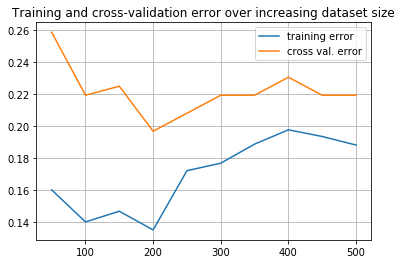

In [471]:
rf_clf = RandomForestClassifier(max_depth=2, random_state=random_state, n_estimators=100)
list_m_errors = []

temp_df_train = df_train.reset_index()
step = 50
for i in range(50, temp_df_train.shape[0], step):
    subset_df_train = temp_df_train[(temp_df_train.index >= 0) & (temp_df_train.index < i)]
    rf_clf.fit(subset_df_train[features_col], subset_df_train["Survived"])
    train_predict = rf_clf.predict(subset_df_train[features_col])
    cv_predict = rf_clf.predict(df_validate[features_col])
    list_m_errors.append([
        i,
        1 - accuracy_score(subset_df_train["Survived"], train_predict),
        1 - accuracy_score(df_validate["Survived"], cv_predict)
    ])

df_m_errors = pd.DataFrame(list_m_errors, columns=["m", "error_training", "error_cross_val"])
plt.title("Training and cross-validation error over increasing dataset size")
plt.plot(df_m_errors["m"], df_m_errors["error_training"])
plt.plot(df_m_errors["m"], df_m_errors["error_cross_val"])
plt.legend(["training error", "cross val. error"], loc="best")
plt.grid()
plt.show()

#### Training over varying `max_depth` value
The training error and cross-validation error are both high. There must be a high bias problem. In the next section, we will increase the depth of the random forest, which adds more complexity to the model and which reduces the bias. If we are lucky, the bias will be low enough to give a fair result.

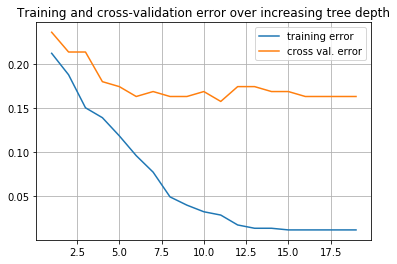

,d,error_training,error_cross_val
0,1,0.212008,0.235955
1,2,0.187617,0.213483
2,3,0.150094,0.213483
3,4,0.138837,0.179775
4,5,0.118199,0.174157
5,6,0.095685,0.162921
6,7,0.076923,0.168539
7,8,0.048780,0.162921
8,9,0.039400,0.162921
9,10,0.031895,0.168539


In [478]:
list_d_errors = []
for i in range(1,20):
    rf_clf = RandomForestClassifier(max_depth=i, random_state=random_state, n_estimators=100)
    rf_clf.fit(df_train[features_col], df_train["Survived"])
    train_predict = rf_clf.predict(df_train[features_col])
    cv_predict = rf_clf.predict(df_validate[features_col])
    list_d_errors.append([
        i,
        1 - accuracy_score(df_train["Survived"], train_predict),
        1 - accuracy_score(df_validate["Survived"], cv_predict)
    ])

df_d_errors = pd.DataFrame(list_d_errors, columns=["d", "error_training", "error_cross_val"])
plt.title("Training and cross-validation error over increasing tree depth")
plt.plot(df_d_errors["d"], df_d_errors["error_training"])
plt.grid()
plt.plot(df_d_errors["d"], df_d_errors["error_cross_val"])
plt.legend(["training error", "cross val. error"], loc="best")
plt.show()

df_d_errors.head(10)

The cross-validation error remains around 16% after the depth is set to 6, while the training error keeps decreasing (overfitting).

#### Tune the random forest hyperparameters

In [482]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [6],
    'max_features': [2, 5, len(features_col)],
    'min_samples_leaf': [3, 5, 10],
    'min_samples_split': [2, 4],
    'n_estimators': [100, 300, 500]
}
rf_clf = RandomForestClassifier()
gs_cv = GridSearchCV(rf_clf, param_grid, cv=7)
gs_cv.fit(df_train[features_col], df_train["Survived"])
gs_cv.best_params_

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'bootstrap': False,
 'max_depth': 6,
 'max_features': 2,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 500}

In [538]:
rf_clf = RandomForestClassifier(**gs_cv.best_params_)
rf_clf.fit(df_train[features_col], df_train["Survived"])

rf_train_predictions = rf_clf.predict(df_train[features_col])

rf_cv_predictions = rf_clf.predict(df_validate[features_col])
accuracy_score(df_validate["Survived"], rf_cv_predictions)

0.8089887640449438

### Neural network classifier

In [539]:
nn_clf = MLPClassifier(solver='lbfgs', alpha=1e-6, hidden_layer_sizes=(5, 5), random_state=random_state)
nn_clf.fit(df_train[features_col], df_train["Survived"])

nn_train_predictions = nn_clf.predict(df_train[features_col])

nn_cv_predictions = nn_clf.predict(df_validate[features_col])
accuracy_score(df_validate["Survived"], nn_cv_predictions)

0.8033707865168539

### Support vector classifier

In [556]:
sv_clf = SVC(kernel="linear", C=0.025)
sv_clf.fit(df_train[features_col], df_train["Survived"])

sv_train_predictions = sv_clf.predict(df_train[features_col])

sv_cv_predictions = sv_clf.predict(df_validate[features_col])
accuracy_score(df_validate["Survived"], sv_cv_predictions)

0.7865168539325843

### Stacking: Naive Bayes, Random Forest and Neural Network

In [552]:
gb_features = ["gaussian_naive_bayes", 
               "random_forest", 
               "neural_network", 
               "support_vector"
              ]

df_gb_train = pd.DataFrame()
df_gb_train[gb_features[0]] = gnb_train_predictions
df_gb_train[gb_features[1]] = rf_train_predictions
df_gb_train[gb_features[2]] = nn_train_predictions
df_gb_train[gb_features[3]] = sv_train_predictions

# Training
gb_clf = GradientBoostingClassifier()
gb_clf.fit(df_gb_train[gb_features], df_train["Survived"])

# Training error
gb_train_predictions = gb_clf.predict(df_gb_train[gb_features])
gb_training_accuracy = accuracy_score(df_train["Survived"], gb_train_predictions)

# Cross-validation error
df_gb_cv = pd.DataFrame()
df_gb_cv[gb_features[0]] = gnb_cv_predictions
df_gb_cv[gb_features[1]] = rf_cv_predictions
df_gb_cv[gb_features[2]] = nn_cv_predictions
df_gb_cv[gb_features[3]] = sv_cv_predictions

gb_cv_predictions = gb_clf.predict(df_gb_cv[gb_features])
gb_cv_accuracy = accuracy_score(df_validate["Survived"], gb_cv_predictions)

print(f"Training accuracy: {gb_training_accuracy} | CV accuracy: {gb_cv_accuracy}")

Training accuracy: 0.8855534709193246 | CV accuracy: 0.8033707865168539
